We can do better.

So this time:
- grid search for better parameters

- Can we make a better RF model? **yes**

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

In [2]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [3]:
def load_data():
    train = pd.read_csv('../input/train.csv')
    test = pd.read_csv('../input/test.csv')
    combined = train.append(test, ignore_index=True).drop(['Id','SalePrice'], axis=1)
    combined = pd.get_dummies(combined)
    combined = combined.fillna(combined.mean())
    y = np.log(train['SalePrice'].values)
    X = combined.iloc[:train.shape[0],:]
    X_submission = combined.iloc[train.shape[0]:,:]
    ids_submission = test['Id'].values
    return y, X, X_submission, ids_submission

In [4]:
# load data
y, X, X_submission, ids_submission = load_data()

In [23]:
# parameters = {'n_estimators': [50],
#               'max_features': [0.2, 0.4, 0.6, 0.8],
#               'max_depth': [7, 11, 15],
#               'min_samples_leaf': [1, 2, 3, 4]}

#{'max_features': 0.4, 'n_estimators': 50, 'max_depth': 15, 'min_samples_leaf': 1}

parameters = {'n_estimators': [50],
              'max_features': [0.2, 0.3, 0.4],
              'max_depth': [15, 16, 17],
              'min_samples_leaf': [1, 2]}

model = GridSearchCV(RandomForestRegressor(), 
                     parameters, 
                     n_jobs= 8,
                     scoring=make_scorer(rmse, greater_is_better=False), 
                     cv=KFold(10, random_state=1773))

In [24]:
%%time
# train grid search
model.fit(X, y)

CPU times: user 3.11 s, sys: 397 ms, total: 3.51 s
Wall time: 26.5 s


GridSearchCV(cv=KFold(n_splits=10, random_state=1773, shuffle=False),
       error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=8,
       param_grid={'n_estimators': [50], 'max_features': [0.2, 0.3, 0.4], 'max_depth': [15, 16, 17], 'min_samples_leaf': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(rmse, greater_is_better=False), verbose=0)

In [25]:
print 'best score:', model.best_score_
print 'best parameters:', model.best_params_

best score: -0.136052600672
best parameters: {'max_features': 0.4, 'n_estimators': 50, 'max_depth': 15, 'min_samples_leaf': 1}


In [15]:
# create submission predictions
preds_submission = model.predict(X_submission)

# save submission
pd.DataFrame({'Id': ids_submission, 'SalePrice': np.exp(preds_submission)})\
  .to_csv('../output/04_gridsearch_RF.csv', index=False)

/Users/dave/.pyenv/versions/anaconda-2.4.0/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


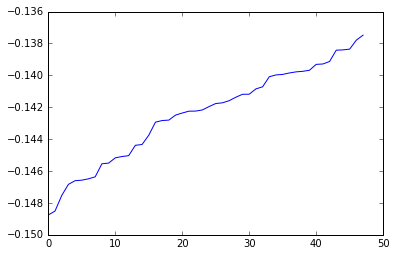

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(np.sort(model.cv_results_['mean_test_score']));